# Seminário prático - Experimentos sobre meta-aprendizado

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from importlib import reload
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, accuracy_score

import aux
from aux import preprocess_default, ALL_ACC, ALL_ACC_SET, \
    drop_draw_set_class, drop_all_vs_rf, print_counter, \
    show_metrics, show_most_important_features
from itertools import combinations
from sklearn.metrics import precision_recall_fscore_support

In [2]:
data = pd.read_csv("meta-base.csv")
data

,general.attrToInst,general.catToNum,general.freqClass.mean,general.freqClass.sd,general.instToAttr,general.nrAttr,general.nrBin,general.nrCat,general.nrClass,general.nrInst,...,C4.5.auc,kNN.acc,kNN.f1m,kNN.auc,SVM.acc,SVM.f1m,SVM.auc,RF.acc,RF.f1m,RF.auc
0,0.100000,0.000000,0.5,0.471405,10.000000,60,0,0,2,600,...,0.993992,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.042056,0.000000,0.5,0.204863,23.777778,9,0,0,2,214,...,0.786753,0.789214,0.764841,0.879050,0.770022,0.733372,0.835946,0.848485,0.822825,0.916196
2,0.121622,5.000000,0.5,0.066888,8.222222,18,9,15,2,148,...,0.813973,0.807071,0.803779,0.887428,0.846863,0.843160,0.927110,0.866887,0.861265,0.941109
3,0.492063,0.148148,0.5,0.145911,2.032258,31,0,4,2,63,...,0.662129,0.663429,0.680036,0.749489,0.761619,0.750802,0.827020,0.785238,0.771251,0.833724
4,0.020833,0.000000,0.5,0.105224,48.000000,7,2,0,2,336,...,0.959853,0.942531,0.941450,0.977326,0.966627,0.965831,0.985190,0.965199,0.964476,0.987683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.223881,0.071429,0.5,0.158307,4.466667,15,1,1,2,67,...,0.779784,0.768214,0.757795,0.843975,0.697202,0.701777,0.808815,0.798333,0.784645,0.858558
396,0.003472,0.000000,0.5,0.283170,288.000000,6,0,6,2,1728,...,0.982767,0.877835,0.844500,0.955360,0.957931,0.950636,0.993741,0.989701,0.987869,0.999346
397,0.021277,0.000000,0.5,0.342688,47.000000,18,0,0,2,846,...,0.969553,0.970795,0.962234,0.993139,0.979193,0.972641,0.996332,0.986998,0.982835,0.998817
398,0.023500,0.000000,0.5,0.565685,42.553191,47,0,0,2,2000,...,0.981546,0.993950,0.983220,0.998558,0.994550,0.984556,0.999174,0.988250,0.965376,0.998578


# Primeiro experimento - 5 Classes

In [3]:
#remove as colunas referentes às medidas f1m e auc
data.drop(data.filter(regex='(.*?\.auc|.*?\.f1m)').columns, axis=1, inplace=True)
data.loc[:, ['landmarking.randomNode.sd', 'landmarking.worstNode.mean', 'landmarking.worstNode.sd', 'ANN.acc', 
             'C4.5.acc', 'kNN.acc', 'SVM.acc', 'RF.acc']]

,landmarking.randomNode.sd,landmarking.worstNode.mean,landmarking.worstNode.sd,ANN.acc,C4.5.acc,kNN.acc,SVM.acc,RF.acc
0,0.038789,0.886667,0.041425,1.000000,0.992000,1.000000,1.000000,1.000000
1,0.089963,0.617662,0.076761,0.708379,0.784846,0.789214,0.770022,0.848485
2,0.123754,0.560536,0.119251,0.837292,0.792357,0.807071,0.846863,0.866887
3,0.160420,0.639048,0.171734,0.767238,0.646000,0.663429,0.761619,0.785238
4,0.110580,0.604069,0.075009,0.961919,0.949307,0.942531,0.966627,0.965199
...,...,...,...,...,...,...,...,...
395,0.160472,0.636310,0.179899,0.770893,0.765179,0.768214,0.697202,0.798333
396,0.018734,0.700249,0.018734,0.999768,0.950167,0.877835,0.957931,0.989701
397,0.041359,0.742169,0.042820,0.982605,0.962633,0.970795,0.979193,0.986998
398,0.008433,0.900000,0.000000,0.994850,0.983450,0.993950,0.994550,0.988250


In [4]:
#remove as amostras com empate (com relação à maior acurácia) e determina as classes
data = drop_draw_set_class(data.copy())
data.loc[:, ['landmarking.randomNode.mean', 'landmarking.randomNode.sd', 'landmarking.worstNode.mean', 'landmarking.worstNode.sd', 'Class']]

,landmarking.randomNode.mean,landmarking.randomNode.sd,landmarking.worstNode.mean,landmarking.worstNode.sd,Class
0,0.655297,0.089963,0.617662,0.076761,RF.acc
1,0.593000,0.123754,0.560536,0.119251,RF.acc
2,0.569762,0.160420,0.639048,0.171734,RF.acc
3,0.674139,0.110580,0.604069,0.075009,SVM.acc
4,0.648228,0.142807,0.643772,0.147598,ANN.acc
...,...,...,...,...,...
378,0.676190,0.160472,0.636310,0.179899,RF.acc
379,0.700249,0.018734,0.700249,0.018734,ANN.acc
380,0.752254,0.041359,0.742169,0.042820,RF.acc
381,0.903000,0.008433,0.900000,0.000000,ANN.acc


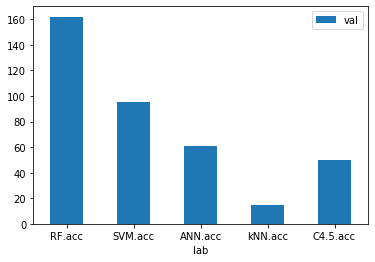

In [5]:
#plota distribuição das classes
X = data.drop('Class', axis=1)
y = data['Class']

vec = list(zip( *[*Counter( y ).items()])) 
gambs = pd.DataFrame(dict(zip(['lab', 'val'],vec))) 
ax = gambs.plot.bar(x='lab', y='val', rot=0) 
plt.show(block=True)

Fold  0  Id:  0


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy: 0.1796875
precision:  0.12960151802656544
recall:  0.22360294117647062
f1_score:  0.13738819866296287
precision_recall_fscore_support : 
	
	[0.17741935 0.1372549  0.         0.33333333 0.        ]
	[0.55       0.41176471 0.         0.15625    0.        ]
	[0.26829268 0.20588235 0.         0.21276596 0.        ]
	[20 17 54 32  5]
Confusion matrix


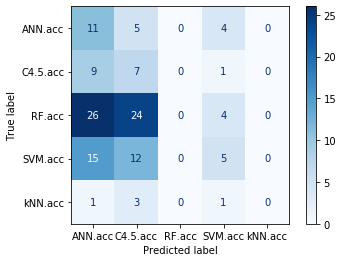


 

Fold  1  Id:  1


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy: 0.1328125
precision:  0.0265625
recall:  0.2
f1_score:  0.04689655172413793
precision_recall_fscore_support : 
	
	[0.        0.1328125 0.        0.        0.       ]
	[0. 1. 0. 0. 0.]
	[0.         0.23448276 0.         0.         0.        ]
	[20 17 54 32  5]
Confusion matrix


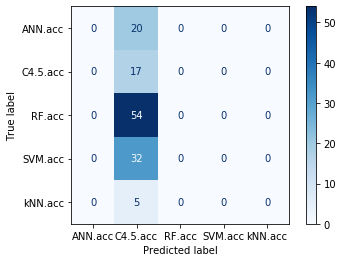


 

Fold  2  Id:  2


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy: 0.07874015748031496
precision:  0.029535232383808098
recall:  0.1525
f1_score:  0.048702147525676934
precision_recall_fscore_support : 
	
	[0.         0.13043478 0.         0.         0.01724138]
	[0.     0.5625 0.     0.     0.2   ]
	[0.         0.21176471 0.         0.         0.03174603]
	[21 16 54 31  5]
Confusion matrix


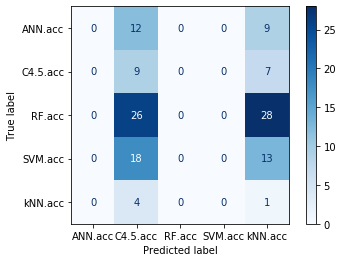


 

------------------------
Considered classes : All 

Mean accuracy =  0.0 



In [6]:
#aplicação do algoritmo Random Forest usando 3-folds cross validation seguido da avaliação das predições

rfc = MLPClassifier(hidden_layer_sizes=(2, 4, 2), max_iter = 2000, 
                    learning_rate_init = 0.000001)
k = 0
acc = 0
acc_sum = 0   
n_splits = 3

skf = StratifiedKFold(n_splits=n_splits)
iii = 0
for k, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold ", k, " Id: ", iii)
    iii += 1
    rfc.fit(X.loc[train_index, :].drop('index', axis=1), y.loc[train_index])
    y_pred = rfc.predict(X.loc[test_index, :].drop('index', axis=1), )
    
    show_metrics(y_true=y.loc[test_index], y_pred=y_pred)
    #matriz de confusão
    print("Confusion matrix")  
    disp = plot_confusion_matrix(rfc, X.loc[test_index, :].drop('index', axis=1), y.loc[test_index],
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    plt.show()
    print("\n \n")

#printa as médias das medidas tiradas nos 10 folds
print("------------------------")
print("Considered classes : All \n")
print("Mean accuracy = ", acc_sum / n_splits, "\n")

# Segundo experimento - Classes dois a dois

Considered classes
RF.acc -> 246
SVM.acc -> 151


Fold  0  Id:  0


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy: 0.6015037593984962
precision:  0.5773493975903614
recall:  0.5767575322812052
f1_score:  0.577017701770177
precision_recall_fscore_support : 
	
	[0.6746988 0.48     ]
	[0.68292683 0.47058824]
	[0.67878788 0.47524752]
	[82 51]


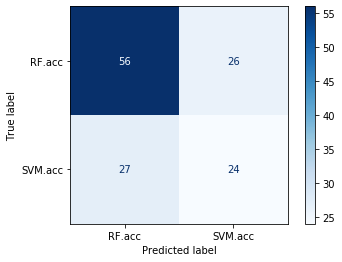


 

Fold  1  Id:  1
accuracy: 0.3787878787878788
precision:  0.1893939393939394
recall:  0.5
f1_score:  0.2747252747252747
precision_recall_fscore_support : 
	
	[0.         0.37878788]
	[0. 1.]
	[0.         0.54945055]
	[82 50]


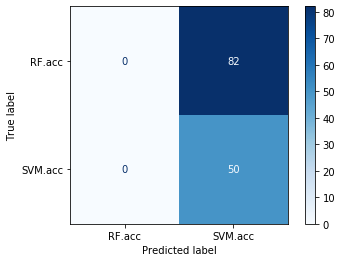


 

Fold  2  Id:  2
accuracy: 0.3712121212121212
precision:  0.3527131782945736
recall:  0.48609756097560974
f1_score:  0.27992113046335854
precision_recall_fscore_support : 
	
	[0.33333333 0.37209302]
	[0.01219512 0.96      ]
	[0.02352941 0.53631285]
	[82 50]


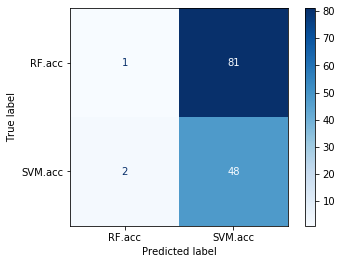


 

Mean accuracy =  0.45050125313283207 

-----------------------

Considered classes
RF.acc -> 304
C4.5.acc -> 89


Fold  0  Id:  3
accuracy: 0.7786259541984732
precision:  0.3893129770992366
recall:  0.5
f1_score:  0.4377682403433476
precision_recall_fscore_support : 
	
	[0.         0.77862595]
	[0. 1.]
	[0.         0.87553648]
	[ 29 102]


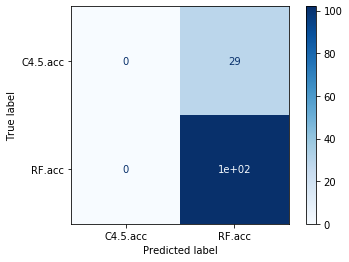


 

Fold  1  Id:  4
accuracy: 0.7022900763358778
precision:  0.5657051282051282
recall:  0.5608910891089108
f1_score:  0.562772785622593
precision_recall_fscore_support : 
	
	[0.33333333 0.79807692]
	[0.3        0.82178218]
	[0.31578947 0.8097561 ]
	[ 30 101]


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


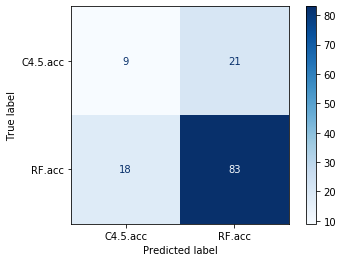


 

Fold  2  Id:  5


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy: 0.7557251908396947
precision:  0.5546666666666666
recall:  0.5135313531353135
f1_score:  0.48475909537856443
precision_recall_fscore_support : 
	
	[0.33333333 0.776     ]
	[0.06666667 0.96039604]
	[0.11111111 0.85840708]
	[ 30 101]


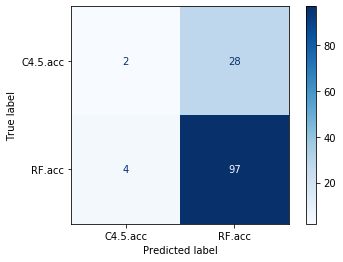


 

Mean accuracy =  0.7455470737913487 

-----------------------

Considered classes
SVM.acc -> 230
C4.5.acc -> 165


Fold  0  Id:  6
accuracy: 0.5681818181818182
precision:  0.4778225806451613
recall:  0.4948051948051948
f1_score:  0.40582800284292825
precision_recall_fscore_support : 
	
	[0.375      0.58064516]
	[0.05454545 0.93506494]
	[0.0952381  0.71641791]
	[55 77]


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


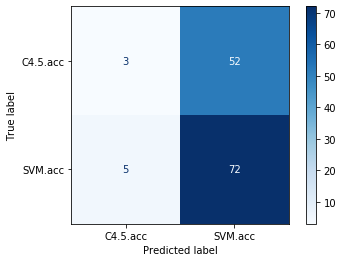


 

Fold  1  Id:  7
accuracy: 0.5833333333333334
precision:  0.2916666666666667
recall:  0.5
f1_score:  0.3684210526315789
precision_recall_fscore_support : 
	
	[0.         0.58333333]
	[0. 1.]
	[0.         0.73684211]
	[55 77]


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


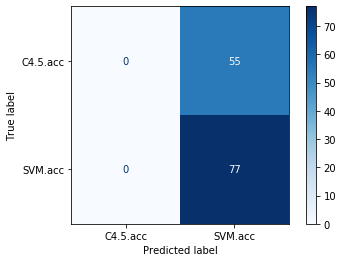


 

Fold  2  Id:  8
accuracy: 0.4198473282442748
precision:  0.2099236641221374
recall:  0.5
f1_score:  0.2956989247311828
precision_recall_fscore_support : 
	
	[0.41984733 0.        ]
	[1. 0.]
	[0.59139785 0.        ]
	[55 76]


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


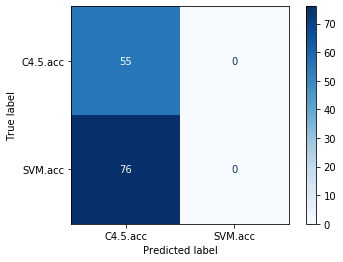


 

Mean accuracy =  0.5237874932531421 

-----------------------

Considered classes
RF.acc -> 347
kNN.acc -> 49


Fold  0  Id:  9
accuracy: 0.8787878787878788
precision:  0.4393939393939394
recall:  0.5
f1_score:  0.46774193548387094
precision_recall_fscore_support : 
	
	[0.87878788 0.        ]
	[1. 0.]
	[0.93548387 0.        ]
	[116  16]


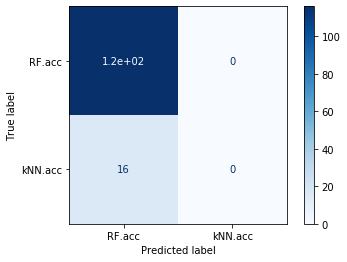


 

Fold  1  Id:  10
accuracy: 0.11363636363636363
precision:  0.22093023255813954
recall:  0.4418103448275862
f1_score:  0.10495508548246885
precision_recall_fscore_support : 
	
	[0.33333333 0.10852713]
	[0.00862069 0.875     ]
	[0.01680672 0.19310345]
	[116  16]


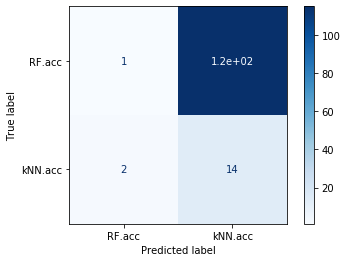


 

Fold  2  Id:  11
accuracy: 0.8712121212121212
precision:  0.4356060606060606
recall:  0.5
f1_score:  0.46558704453441296
precision_recall_fscore_support : 
	
	[0.87121212 0.        ]
	[1. 0.]
	[0.93117409 0.        ]
	[115  17]


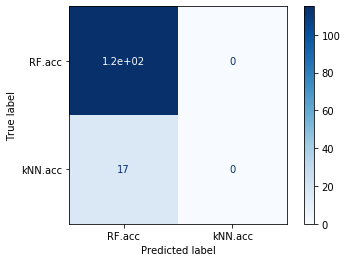


 

Mean accuracy =  0.6212121212121212 

-----------------------

Considered classes
kNN.acc -> 79
SVM.acc -> 317


Fold  0  Id:  12


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy: 0.7575757575757576
precision:  0.557207498383969
recall:  0.5312169312169313
f1_score:  0.5285714285714285
precision_recall_fscore_support : 
	
	[0.80672269 0.30769231]
	[0.91428571 0.14814815]
	[0.85714286 0.2       ]
	[105  27]


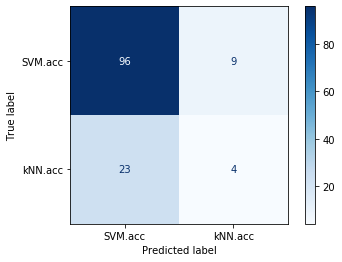


 

Fold  1  Id:  13
accuracy: 0.803030303030303
precision:  0.4015151515151515
recall:  0.5
f1_score:  0.4453781512605042
precision_recall_fscore_support : 
	
	[0.8030303 0.       ]
	[1. 0.]
	[0.8907563 0.       ]
	[106  26]


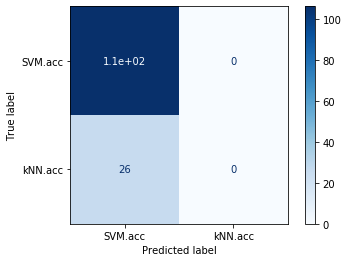


 

Fold  2  Id:  14
accuracy: 0.19696969696969696
precision:  0.09848484848484848
recall:  0.5
f1_score:  0.16455696202531644
precision_recall_fscore_support : 
	
	[0.        0.1969697]
	[0. 1.]
	[0.         0.32911392]
	[106  26]


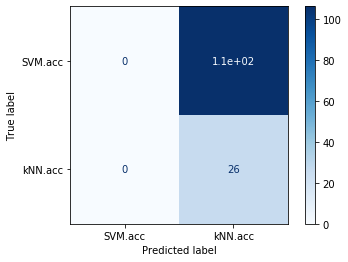


 

Mean accuracy =  0.5858585858585859 

-----------------------

Considered classes
kNN.acc -> 120
C4.5.acc -> 277


Fold  0  Id:  15
accuracy: 0.3007518796992481
precision:  0.15037593984962405
recall:  0.5
f1_score:  0.23121387283236994
precision_recall_fscore_support : 
	
	[0.         0.30075188]
	[0. 1.]
	[0.         0.46242775]
	[93 40]


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


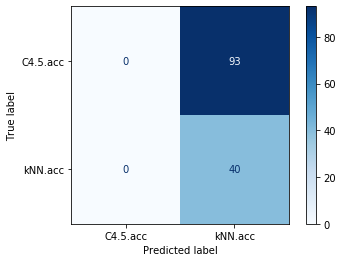


 

Fold  1  Id:  16
accuracy: 0.30303030303030304
precision:  0.4
recall:  0.49293478260869567
f1_score:  0.24005006257822276
precision_recall_fscore_support : 
	
	[0.5 0.3]
	[0.01086957 0.975     ]
	[0.0212766  0.45882353]
	[92 40]


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


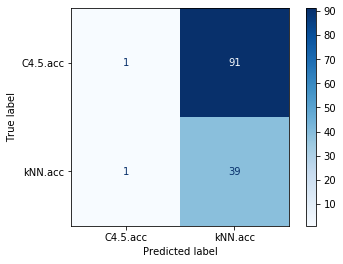


 

Fold  2  Id:  17
accuracy: 0.696969696969697
precision:  0.3484848484848485
recall:  0.5
f1_score:  0.41071428571428575
precision_recall_fscore_support : 
	
	[0.6969697 0.       ]
	[1. 0.]
	[0.82142857 0.        ]
	[92 40]


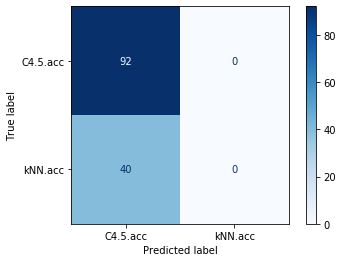


 

Mean accuracy =  0.43358395989974935 

-----------------------

Considered classes
RF.acc -> 271
ANN.acc -> 118


Fold  0  Id:  18
accuracy: 0.7
precision:  0.35
recall:  0.5
f1_score:  0.4117647058823529
precision_recall_fscore_support : 
	
	[0.  0.7]
	[0. 1.]
	[0.         0.82352941]
	[39 91]


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


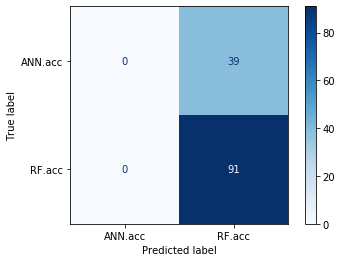


 

Fold  1  Id:  19
accuracy: 0.36153846153846153
precision:  0.46044588277597986
recall:  0.46944444444444444
f1_score:  0.3550893550893551
precision_recall_fscore_support : 
	
	[0.29126214 0.62962963]
	[0.75       0.18888889]
	[0.41958042 0.29059829]
	[40 90]


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


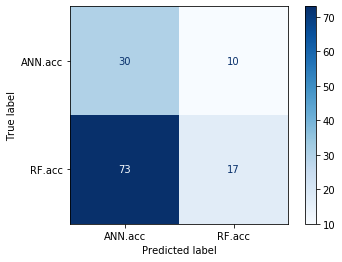


 

Fold  2  Id:  20
accuracy: 0.3023255813953488
precision:  0.1511627906976744
recall:  0.5
f1_score:  0.23214285714285712
precision_recall_fscore_support : 
	
	[0.30232558 0.        ]
	[1. 0.]
	[0.46428571 0.        ]
	[39 90]


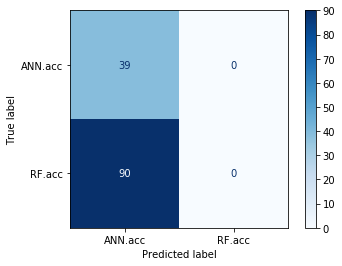


 

Mean accuracy =  0.45462134764460344 

-----------------------

Considered classes
SVM.acc -> 225
ANN.acc -> 170


Fold  0  Id:  21
accuracy: 0.4696969696969697
precision:  0.43846354847138747
recall:  0.44491228070175437
f1_score:  0.4365853658536586
precision_recall_fscore_support : 
	
	[0.34883721 0.52808989]
	[0.26315789 0.62666667]
	[0.3        0.57317073]
	[57 75]


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


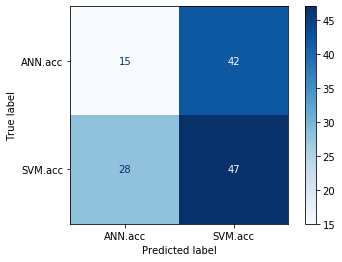


 

Fold  1  Id:  22


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy: 0.5681818181818182
precision:  0.2840909090909091
recall:  0.5
f1_score:  0.36231884057971014
precision_recall_fscore_support : 
	
	[0.         0.56818182]
	[0. 1.]
	[0.         0.72463768]
	[57 75]


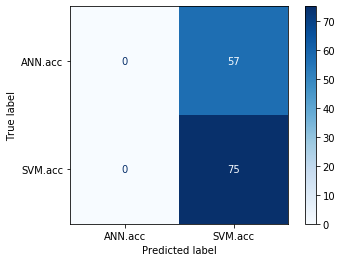


 

Fold  2  Id:  23
accuracy: 0.42748091603053434
precision:  0.21374045801526717
recall:  0.5
f1_score:  0.2994652406417112
precision_recall_fscore_support : 
	
	[0.42748092 0.        ]
	[1. 0.]
	[0.59893048 0.        ]
	[56 75]


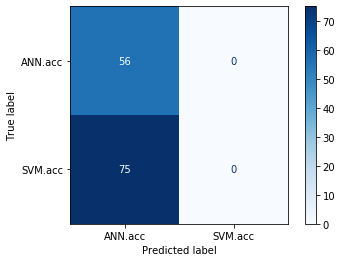


 

Mean accuracy =  0.4884532346364408 

-----------------------

Considered classes
ANN.acc -> 214
C4.5.acc -> 178


Fold  0  Id:  24
accuracy: 0.5725190839694656
precision:  0.78125
recall:  0.5254237288135594
f1_score:  0.40838709677419355
precision_recall_fscore_support : 
	
	[0.5625 1.    ]
	[1.         0.05084746]
	[0.72       0.09677419]
	[72 59]


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


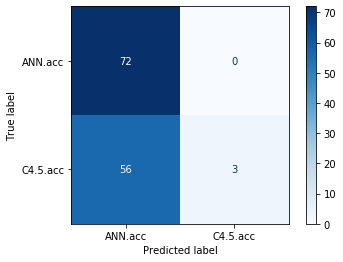


 

Fold  1  Id:  25
accuracy: 0.5343511450381679
precision:  0.2692307692307692
recall:  0.49295774647887325
f1_score:  0.3482587064676617
precision_recall_fscore_support : 
	
	[0.53846154 0.        ]
	[0.98591549 0.        ]
	[0.69651741 0.        ]
	[71 60]


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


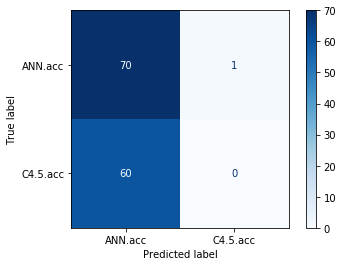


 

Fold  2  Id:  26
accuracy: 0.47692307692307695
precision:  0.519203413940256
recall:  0.5096681785629028
f1_score:  0.4222222222222223
precision_recall_fscore_support : 
	
	[0.57894737 0.45945946]
	[0.15492958 0.86440678]
	[0.24444444 0.6       ]
	[71 59]


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


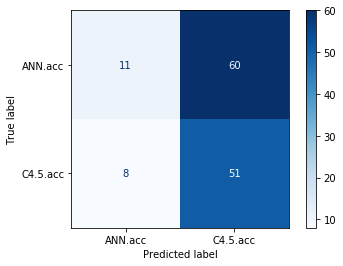


 

Mean accuracy =  0.5279311019769035 

-----------------------

Considered classes
kNN.acc -> 82
ANN.acc -> 313


Fold  0  Id:  27
accuracy: 0.21212121212121213
precision:  0.10606060606060606
recall:  0.5
f1_score:  0.175
precision_recall_fscore_support : 
	
	[0.         0.21212121]
	[0. 1.]
	[0.   0.35]
	[104  28]


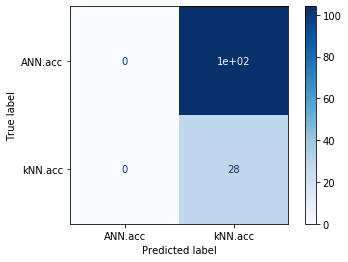


 

Fold  1  Id:  28
accuracy: 0.5833333333333334
precision:  0.5029761904761905
recall:  0.5042328042328041
f1_score:  0.48783068783068784
precision_recall_fscore_support : 
	
	[0.79761905 0.20833333]
	[0.63809524 0.37037037]
	[0.70899471 0.26666667]
	[105  27]


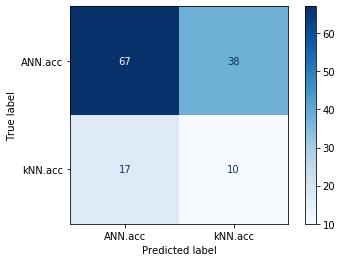


 

Fold  2  Id:  29
accuracy: 0.7938931297709924
precision:  0.3969465648854962
recall:  0.5
f1_score:  0.4425531914893617
precision_recall_fscore_support : 
	
	[0.79389313 0.        ]
	[1. 0.]
	[0.88510638 0.        ]
	[104  27]


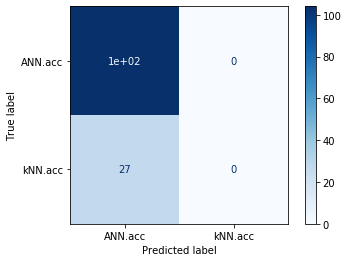


 

Mean accuracy =  0.5297825584085126 

-----------------------



In [9]:
from sklearn.metrics import precision_recall_fscore_support
reload(aux)
comb_to_drop = list(combinations(ALL_ACC, r=3))
raw = pd.read_csv('meta-base.csv')

acc_mean_list = []
#para cada combinação de 3 colunas, dropa essas 3 deixando 2 colunas para o problema de classificação
#faz o pre_processamento do dataframe passando as colunas consideradas
# (retira os empates e seta as classes)
# divide o data em features e rótulo e divide os folds
iii = 0
for to_drop in comb_to_drop:
    data = raw.drop(list(to_drop), axis=1)
    considered_classes = ALL_ACC_SET - set(to_drop)
    data = preprocess_default(data, list(considered_classes))
    rfc = MLPClassifier(hidden_layer_sizes=(2, 4, 2), max_iter = 10000, 
                        learning_rate_init = 0.00001) 
    X = data.drop('Class', axis=1)
    y = data['Class']
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits)
    acc_list = []
    print("Considered classes")
    print_counter(y)
    print("\n")
    
    for k, (train_index, test_index) in enumerate(skf.split(X, y)):
        print("Fold ", k, " Id: ", iii)
        iii += 1
        rfc.fit(X.loc[train_index, :], y.loc[train_index])
        y_pred = rfc.predict(X.loc[test_index, :], )
        
        acc_list.append(accuracy_score(y_true=y.loc[test_index], y_pred=y_pred))
        
        aux.show_metrics(y_true=y.loc[test_index], y_pred=y_pred)
        
        #matriz de confusão
        disp = plot_confusion_matrix(rfc, X.loc[test_index, :], y.loc[test_index],
                                 display_labels=None,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
        plt.show()
        print("\n \n")

    print("Mean accuracy = ", np.mean(acc_list) , "\n")
    acc_mean_list.append(np.mean(acc_list))
    print("-----------------------\n")
 
    

# Terceiro experimento - Random Forest x Outros

Considered classes
RF.acc -> 162
Other -> 221


Fold  0  Id:  0


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy: 0.42857142857142855
precision:  0.21428571428571427
recall:  0.5
f1_score:  0.3
precision_recall_fscore_support : 
	
	[0.         0.42857143]
	[0. 1.]
	[0.  0.6]
	[44 33]


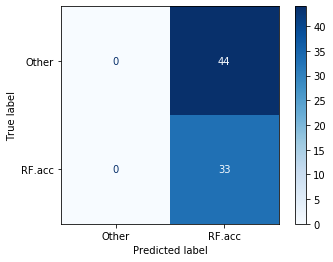


 

Fold  1  Id:  1


/home/leomaffei/test/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy: 0.42857142857142855
precision:  0.436046511627907
recall:  0.4356060606060606
f1_score:  0.4284750337381916
precision_recall_fscore_support : 
	
	[0.5        0.37209302]
	[0.38636364 0.48484848]
	[0.43589744 0.42105263]
	[44 33]


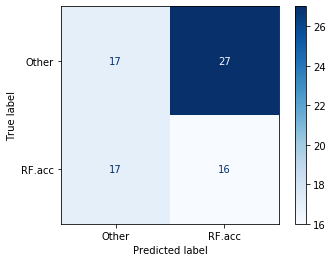


 

Fold  2  Id:  2
accuracy: 0.5714285714285714
precision:  0.4572072072072072
recall:  0.4934027777777778
f1_score:  0.3899159663865546
precision_recall_fscore_support : 
	
	[0.58108108 0.33333333]
	[0.95555556 0.03125   ]
	[0.72268908 0.05714286]
	[45 32]


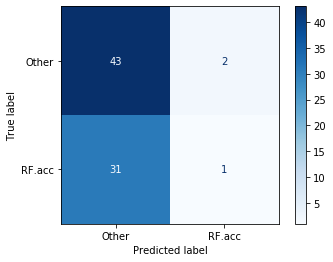


 

Fold  3  Id:  3
accuracy: 0.5526315789473685
precision:  0.45238095238095233
recall:  0.48579545454545453
f1_score:  0.40350877192982454
precision_recall_fscore_support : 
	
	[0.57142857 0.33333333]
	[0.90909091 0.0625    ]
	[0.70175439 0.10526316]
	[44 32]


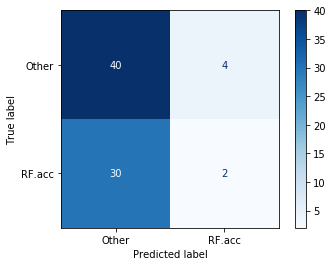


 

Fold  4  Id:  4
accuracy: 0.42105263157894735
precision:  0.21052631578947367
recall:  0.5
f1_score:  0.2962962962962963
precision_recall_fscore_support : 
	
	[0.         0.42105263]
	[0. 1.]
	[0.         0.59259259]
	[44 32]


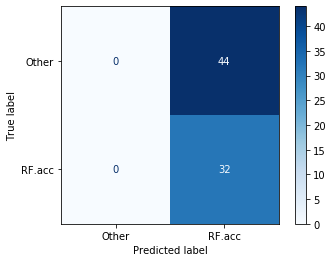


 

Mean accuracy =  0.48045112781954885 

-----------------------



In [11]:
data_rf_all = drop_all_vs_rf(pd.read_csv('meta-base.csv'))
data_rf_all.drop(data_rf_all.filter(regex='(.*?\.auc|.*?\.f1m)').columns, axis=1, inplace=True)

#para cada combinação de 3 colunas, dropa essas 3 deixando 2 colunas para o problema de classificação
#faz o pre_processamento do dataframe passando as colunas consideradas (retira os empates e seta as classes)
#divide o data em features e rótulo e divide os folds
data = data_rf_all
rfc = MLPClassifier(hidden_layer_sizes=(2, 4, 2), max_iter = 15000, 
                        learning_rate_init = 0.00001)
X = data.drop('Class', axis=1)
y = data['Class']
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=42,
                      shuffle=True)
acc_list = []
print("Considered classes")
print_counter(y)
print("\n")
iii = 0
for k, (train_index, test_index) in enumerate(skf.split(X, y)):
    print("Fold ", k, " Id: ", iii)
    iii += 1    
    rfc.fit(X.loc[train_index, :], y.loc[train_index])
    y_pred = rfc.predict(X.loc[test_index, :], )
    
    acc_list.append(accuracy_score(y_true=y.loc[test_index], y_pred=y_pred))

    aux.show_metrics(y_true=y.loc[test_index], y_pred=y_pred)
    
    #matriz de confusão
    disp = plot_confusion_matrix(rfc, X.loc[test_index, :], y.loc[test_index],
                             display_labels=None,
                             cmap=plt.cm.Blues,
                             normalize=None)
    plt.show()
    print("\n \n")

print("Mean accuracy = ", np.mean(acc_list), "\n")
print("-----------------------\n")
